# "A guided introduction to building a Deep Recurrent Neural Network (DRNN) from scratch"

> "This notebook explain and describe how to desing a deep RNN and then introduce us to the LSTM and GRU cells, a more advanced RNN designed to solve some well-known limitations of the deep, large, RNN. As the previous notebook, the texts and code section are extracted from the great book Hands-on Machine Learning with Scikit Learn ad Tensorflow First Edition"

- toc: true
- branch: master
- badges: false
- comments: false
- categories: [fastpages, jupyter, RNN, Tensorflow1]
- hide: false
- search_exclude: true

## Deep Recurrent Neural Network using TensorFlow 1 and Keras lybrary

This notebook explain and describe how to desing a deep RNN and then introduce us to the LSTM and GRU cells, a more advanced RNN designed to solve some well-known limitations of the deep, large, RNN. As the previous notebook, **the texts and code section are extracted from the great book  "Hands-on Machine Learning with Scikit Learn ad Tensorflow First Edition". We highly encourage you to read it.**

It is quite common to stack multiple layers of cells. This gives you a deep RNN.
To implement a deep RNN in TensorFlow, you can create several cells and stack them
into a MultiRNNCell. In the following code we stack three identical cells

In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf
import numpy as np

# Ignore and hide warnings
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [2]:
n_steps=20 # This will be defined in every example
t_min, t_max = 0, 30
resolution = 0.1
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

## Multi RNNCell

Now we can create our multiple layer RNN using a MultiRNNCell and unrolling it. 

In [5]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [6]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)


init = tf.global_variables_initializer()

The states variable is a tuple containing one tensor per layer,
each representing the final state of that layer’s cell (with shape [batch_size, n_neu
rons]). If you set state_is_tuple=False when creating the MultiRNNCell, then
states becomes a single tensor containing the states from every layer, concatenated
along the column axis (i.e., its shape is [batch_size, n_layers * n_neurons]).

In [7]:
X_batch = np.random.rand(2, n_steps, n_inputs)

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [8]:
outputs_val.shape

(2, 5, 100)

## Applying Dropout

If you build a very deep RNN, it may end up overfitting the training set. To prevent
that, a common technique is to apply dropout. You can
simply add a dropout layer before or after the RNN as usual, but if you also want to
apply dropout between the RNN layers, you need to use a DropoutWrapper.

The following
code applies dropout to the inputs of each layer in the RNN:

In [9]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

keep_prob = 0.5

cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


The rest of the construction phase is like earlier

In [10]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


Unfortunately, this code is only usable for training, because the DropoutWrapper class has no training parameter, so it always applies dropout, even when the model is not being trained, so we must first train the model, then create a different model for testing, without the DropoutWrapper.

In [11]:
n_iterations = 500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 16.623817
100 Training MSE: 4.6660967
200 Training MSE: 3.925847
300 Training MSE: 3.512689
400 Training MSE: 2.8907187


Now that the model is trained, we need to create the model again, but without the DropoutWrapper for testing:
**Another option is set keep_prob to 1.0 in a new model for testing__**

In [12]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

keep_prob = 0.5

cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


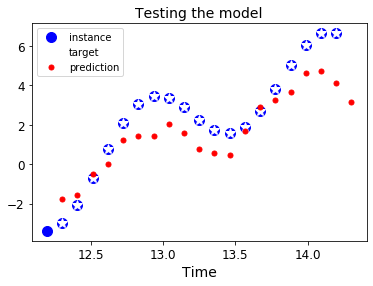

In [13]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. 

## Handling long sequences

To train an RNN on long sequences, you will need to run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the vanishing/exploding gradients problem and take forever to train. Many of the tricks to alleviate this problem can be used for deep unrolled RNNs as well: good parameter initialization,
nonsaturating activation functions (e.g., ReLU), Batch Normalization, Gradient Clipping, and faster optimizers. However, if the RNN needs to handle even moderately long sequences (e.g., 100 inputs), then training will still be very slow.

The simplest and most common solution to this problem is to unroll the RNN only
over a limited number of time steps during training. This is called truncated backpropagation
through time. In TensorFlow you can implement it simply by truncating the
input sequences. The problem, of course, is that the model will
not be able to learn long-term patterns.

second problem faced by long-running RNNs is the
fact that the memory of the first inputs gradually fades away. Indeed, due to the transformations
that the data goes through when traversing an RNN, some information is
lost after each time step.



## LSTM

If you consider the LSTM cell as a black box, it can be used very much like a basic cell,
except it will perform much better; training will converge faster and it will detect
long-term dependencies in the data. In TensorFlow, you can simply use a BasicLSTM
Cell instead of a BasicRNNCell:

In [15]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [17]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

In [18]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [19]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [15]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.97333336 Test accuracy = 0.9481
Epoch 1 Train accuracy = 0.97333336 Test accuracy = 0.9703
Epoch 2 Train accuracy = 0.97333336 Test accuracy = 0.9709
Epoch 3 Train accuracy = 1.0 Test accuracy = 0.9786
Epoch 4 Train accuracy = 0.98 Test accuracy = 0.9816
Epoch 5 Train accuracy = 0.99333334 Test accuracy = 0.9846
Epoch 6 Train accuracy = 0.99333334 Test accuracy = 0.9862
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9852
Epoch 8 Train accuracy = 0.9866667 Test accuracy = 0.9884
Epoch 9 Train accuracy = 0.99333334 Test accuracy = 0.9876


LSTM cells manage two state vectors, and for performance reasons they are kept
separate by default. You can change this default behavior by setting
state_is_tuple=False when creating the BasicLSTMCell.

The key idea is that the network can learn what to store in the
long-term state, what to throw away, and what to read from it. As the long-term state
c(t–1) traverses the network from left to right, you can see that it first goes through a
forget gate, dropping some memories, and then it adds some new memories via the
addition operation (which adds the memories that were selected by an input gate).
The result c(t) is sent straight out, without any further transformation. So, at each time
step, some memories are dropped and some memories are added. Moreover, after the
addition operation, the long-term state is copied and passed through the tanh function,
and then the result is filtered by the output gate. This produces the short-term
state h(t) (which is equal to the cell’s output for this time step y(t)).

In short, an LSTM cell can learn to recognize an important input (that’s the role of the
input gate), store it in the long-term state, learn to preserve it for as long as it is
needed (that’s the role of the forget gate), and learn to extract it whenever it is needed.
This explains why they have been amazingly successful at capturing long-term patterns
in time series, long texts, audio recordings, and more.

### PEEPHOLE Connection

In a basic LSTM cell, the gate controllers can look only at the input x(t) and the previous
short-term state h(t–1). It may be a good idea to give them a bit more context by
letting them peek at the long-term state as well. This idea was proposed by Felix Gers
and Jürgen Schmidhuber in 2000.6 They proposed an LSTM variant with extra connections
called peephole connections: the previous long-term state c(t–1) is added as an
input to the controllers of the forget gate and the input gate, and the current longterm
state c(t) is added as input to the controller of the output gate.
To implement peephole connections in TensorFlow, you must use the LSTMCell
instead of the BasicLSTMCell and set use_peepholes=True:


In [16]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


## GRU Cells

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as
well (which explains its growing popularity). The main simplifications are:

• Both state vectors are merged into a single vector h(t).
• A single gate controller controls both the forget gate and the input gate. If the
gate controller outputs a 1, the forget gate is open and the input gate is closed. If
it outputs a 0, the opposite happens. In other words, whenever a memory must
be stored, the location where it will be stored is erased first. This is actually a frequent
variant to the LSTM cell in and of itself.
• There is no output gate; the full state vector is output at every time step. However,
there is a new gate controller that controls which part of the previous state
will be shown to the main layer.

In [34]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


gru_cells = [tf.nn.rnn_cell.GRUCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(gru_cells)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [35]:
#Train the model
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./gru_time_series_model")

0 	MSE: 14.013569
100 	MSE: 0.49593905
200 	MSE: 0.12562285
300 	MSE: 0.05490951
400 	MSE: 0.06835106
500 	MSE: 0.058419418
600 	MSE: 0.050165113
700 	MSE: 0.047782168
800 	MSE: 0.048071586
900 	MSE: 0.05129924
1000 	MSE: 0.04340675
1100 	MSE: 0.041156635
1200 	MSE: 0.036301177
1300 	MSE: 0.042271547
1400 	MSE: 0.043177534


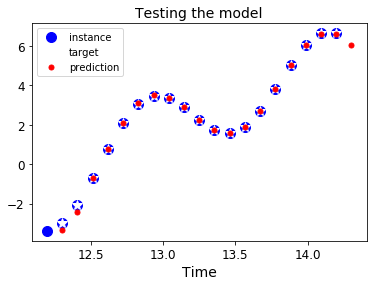

In [36]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()